In [1]:
import os
import sys

import numpy as np
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import colors
from hydra import initialize, compose
import pickle
from glob import glob
from pprint import pprint
from tqdm import tqdm
import csv
import os
from astropy import units as u
import speclite.filters

# set paths to various directories based on the machine this code is being executed on
with initialize(version_base=None, config_path='config'):
    config = compose(config_name='config.yaml')  # overrides=['machine=uzay']

array_dir, data_dir, figure_dir, pickle_dir, repo_dir  = config.machine.array_dir, config.machine.data_dir, config.machine.figure_dir, config.machine.pickle_dir, config.machine.repo_dir

# enable use of local modules
if repo_dir not in sys.path:
    sys.path.append(repo_dir)

# set matplotlib style
plt.style.use(f'{repo_dir}/mejiro/mplstyle/science.mplstyle')

from mejiro.lenses.test import SampleStrongLens
from mejiro.plots import diagnostic_plot, plot, plot_util, overplot
from mejiro.analysis import stats
from mejiro.utils import util
from mejiro.helpers import gs

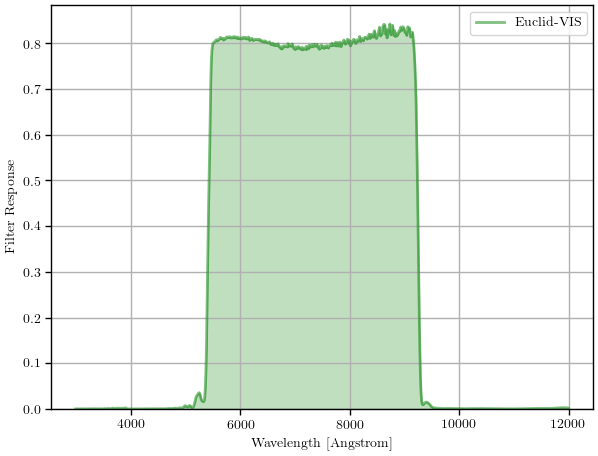

In [4]:
euclid = speclite.filters.load_filters('Euclid-VIS')
speclite.filters.plot_filters(euclid)

In [2]:
_filter_name_list = [
    "F062",
    "F087",
    "F106",
    "F129",
    "F158",
    "F184",
    "F146",
    "F213",
    "SNPrism",
    "Grism_1stOrder",
    "Grism_0thOrder",
]

In [3]:
def configure_hwo_filters():
    """

    :return: Roman filters stored and accessible in speclite
    """
    import mejiro
    module_path = os.path.dirname(mejiro.__file__)
    file_name_roman = os.path.join(module_path, 'data', 'Roman_effarea_20201130.csv')

    responses = {
        "F062": [],
        "F087": [],
        "F106": [],
        "F129": [],
        "F158": [],
        "F184": [],
        "F146": [],
        "F213": [],
        "SNPrism": [],
        "Grism_1stOrder": [],
        "Grism_0thOrder": [],
    }

    group_name = "HWO"
    wave = []

    area = (6.5 / 2) ** 2 * np.pi  # HWO mirror diameter is expected to be 6.5 meters
    # divide by the area as the throughputs are given in effective area in m^2

    with open(file_name_roman, newline="") as myFile:
        reader = csv.DictReader(myFile)
        for row in reader:
            wave.append(float(row["Wave"]))
            for name in _filter_name_list:
                responses[name].append(float(row[name]) / area)
    wave = np.array(wave)

    # convert micrometer to Angstrom
    wavelength = wave * 10000 * u.Angstrom

    for i, filter_name in enumerate(_filter_name_list):
        response = np.array(responses[filter_name])

        # for speclite the response curve must start with 0 and end with 0
        if response[0] != 0:
            wavelength = np.insert(wavelength, 0, min(wavelength) - 100 * u.Angstrom)
            response = np.insert(response, 0, 0)
        if response[-1] != 0:
            wavelength = np.append(wavelength, max(wavelength) + 100 * u.Angstrom)
            response = np.append(response, 0)

        speclite_filter = speclite.filters.FilterResponse(
            wavelength=wavelength,
            response=response,
            meta=dict(group_name=group_name, band_name=filter_name),
        )

        save_path = os.path.join(module_path, 'data', 'hwo_speclite_filters')
        util.create_directory_if_not_exists(save_path)
        util.clear_directory(save_path)
        speclite_filter.save(save_path)

In [4]:
def filter_names():
    """

    :return: list of filter names with full path
    """
    import mejiro
    module_path = os.path.dirname(mejiro.__file__)
    save_path = os.path.join(module_path, 'data', 'hwo_speclite_filters')
    _filter_names = [
        str(save_path + "HWO-" + name + ".ecsv") for name in _filter_name_list
    ]
    return _filter_names

In [5]:
# load Roman WFI filters
configure_hwo_filters()
roman_filters = filter_names()
roman_filters.sort()
# _ = speclite.filters.load_filters(*roman_filters[:8])

KeyError: 'Wave'